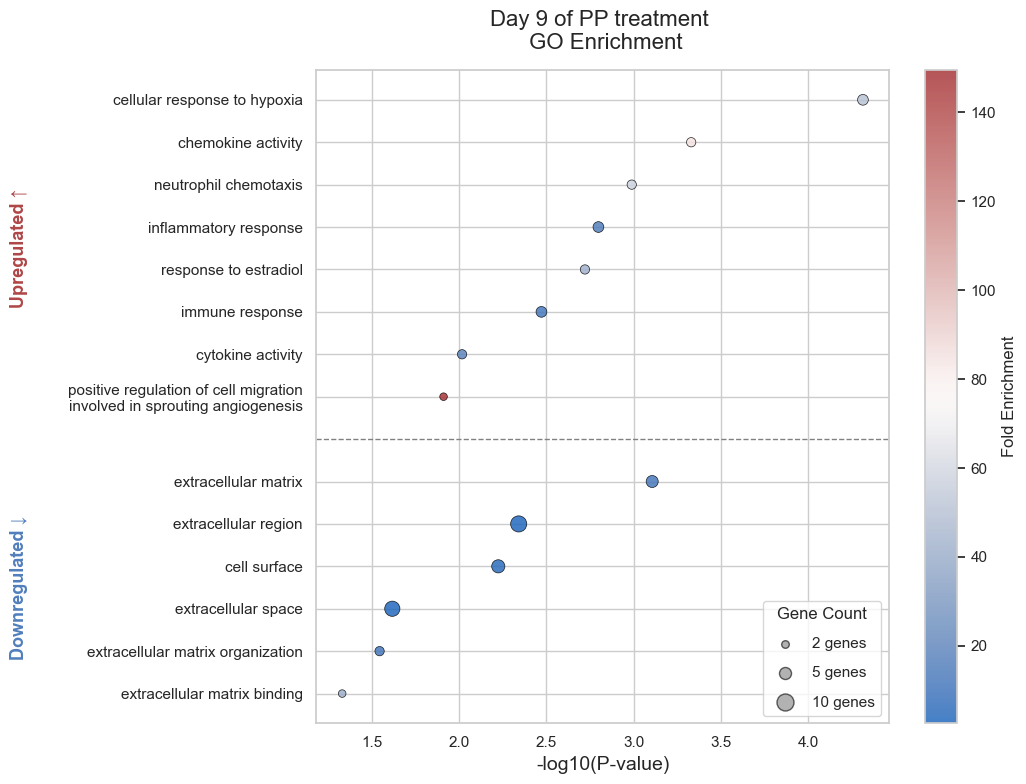

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.rcParams['font.family'] = 'Calibri'

# Load data
df = pd.read_excel('GO_PT_Day9.xlsx')  # podmień nazwę pliku

# Remove GO term prefixes like "GO:0045236~"
df['Clean Term'] = df['Term'].apply(lambda x: re.sub(r'^.*?~', '', x))

# Replace one specific label with a two-line version for readability
df['Clean Term'] = df['Clean Term'].replace(
    'positive regulation of cell migration involved in sprouting angiogenesis',
    'positive regulation of cell migration\ninvolved in sprouting angiogenesis'
)

# List of selected GO terms to include in the plot
terms_to_plot = [
    'cellular response to hypoxia',
    'chemokine activity',
    'neutrophil chemotaxis',
    'inflammatory response',
    'response to estradiol',
    'immune response',
    'cytokine activity',
    'positive regulation of cell migration\ninvolved in sprouting angiogenesis',
    'extracellular matrix',
    'extracellular region',
    'cell surface',
    'extracellular space',
    'extracellular matrix organization',
    'extracellular matrix binding'
]

df = df[df['Clean Term'].isin(terms_to_plot)]

# Set categorical order for regulation
df['Regulation'] = pd.Categorical(df['Regulation'], categories=['Up', 'Down'], ordered=True)

# Calculate -log10(p-value)
df['minus_log10_p'] = -np.log10(df['PValue'])

# Split into Up and Down groups
df_up = df[df['Regulation'] == 'Up'].copy()
df_down = df[df['Regulation'] == 'Down'].copy()

# Sort by p-value within each group
df_up = df_up.sort_values('PValue')
df_down = df_down.sort_values('PValue')

# Assign Y positions for each term (separated per group)
df_up['y_pos'] = range(len(df_up), 0, -1)
df_down['y_pos'] = range(-1, -len(df_down)-1, -1)

# Combine Up and Down into one plotting DataFrame
df_plot = pd.concat([df_up, df_down])

# Calculate Y position for dashed group separator line
separator_y = (df_up['y_pos'].min() + df_down['y_pos'].max()) / 2

# Prepare cleaned labels for y-axis
df_plot['Clean Term Label'] = df_plot['Clean Term']

# Scale dot sizes by gene count (adjust multiplier if needed)
df_plot['size'] = df_plot['Count'] * 15  # dostosuj skalowanie

# Sort by Y position
df_plot = df_plot.sort_values('y_pos')

# Create dot plot
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')

scatter = plt.scatter(
    x=df_plot['minus_log10_p'],
    y=df_plot['y_pos'],
    s=df_plot['size'],
    c=df_plot['Fold Enrichment'],
    cmap='vlag',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85
)

# Color bar for fold enrichment
cbar = plt.colorbar(scatter)
cbar.set_label('Fold Enrichment', fontsize=12)

# Legend for dot size (gene count)
for size in [2, 5, 10]:
    plt.scatter([], [], s=size*15, c='gray', alpha=0.6, edgecolor='black', label=f'{size} genes')

plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Gene Count', loc='lower right')

# Set Y-axis labels with clean term names
plt.yticks(df_plot['y_pos'], df_plot['Clean Term Label'], fontsize=11)

plt.xlabel('-log10(P-value)', fontsize=14)
plt.title('Day 9 of PP treatment \n GO Enrichment', fontsize=16, pad=15)

plt.xticks(fontsize=11)
plt.tight_layout()

# Dashed line separating Up and Downregulated terms
plt.axhline(y=separator_y, color='gray', linestyle='--', linewidth=1)

# Annotations for Up/Down groups on Y-axis
plt.text(
    x=df_plot['minus_log10_p'].min() - 1.8,  # dostosuj pozycję X w razie potrzeby
    y=df_up['y_pos'].median(),
    s='Upregulated ↑',
    va='center',
    ha='right',
    rotation=90,
    fontsize=13,
    fontweight='bold',
    color='#AF4647'
)

plt.text(
    x=df_plot['minus_log10_p'].min() - 1.8,
    y=df_down['y_pos'].median(),
    s='Downregulated ↓',
    va='center',
    ha='right',
    rotation=90,
    fontsize=13,
    fontweight='bold',
    color='#517FBC'
)

#plt.savefig('GO Enrichment_PT_Day9_poster.png', bbox_inches='tight', pad_inches=0.1)
plt.show()